In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
def get_unique_data(target_dataframe, end_target_columns):
    # Get the number of columns
    n_cols = target_dataframe.shape[1]

    # Get the last 7 columns
    df_last_7_columns = target_dataframe.iloc[:, -end_target_columns:]

    # Create a dictionary to store the unique values with their column name
    unique_values = {col: df_last_7_columns[col].unique() for col in df_last_7_columns.columns}

    # Create a new Series from the dictionary
    unique_series = pd.Series(unique_values)
    return unique_series

# 1: Dataframe analysis

In [3]:
# Load the data from the CSV file
dev_df = pd.read_csv('development.csv')
dev_df.drop('Id', axis=1, inplace=True)

#TODO REMOVE ME
dev_df = dev_df.sample(frac=0.01, random_state=42)
df_unique_data = get_unique_data(dev_df, 7)
df_unique_data

action                                   [decrease, change language, increase, activate...
object                                                 [volume, heat, none, music, lights]
Self-reported fluency level                                      [native, advanced, basic]
First Language spoken                           [English (United States), French (Canada)]
Current language used for work/school    [English (United States), English (Australia),...
gender                                                                      [male, female]
ageRange                                                               [41-65, 22-40, 65+]
dtype: object

In [4]:
eval_df = pd.read_csv('evaluation.csv')

df_unique_data = get_unique_data(eval_df, 4)
df_unique_data

First Language spoken                    [English (United States)]
Current language used for work/school    [English (United States)]
gender                                              [male, female]
ageRange                                            [22-40, 41-65]
dtype: object

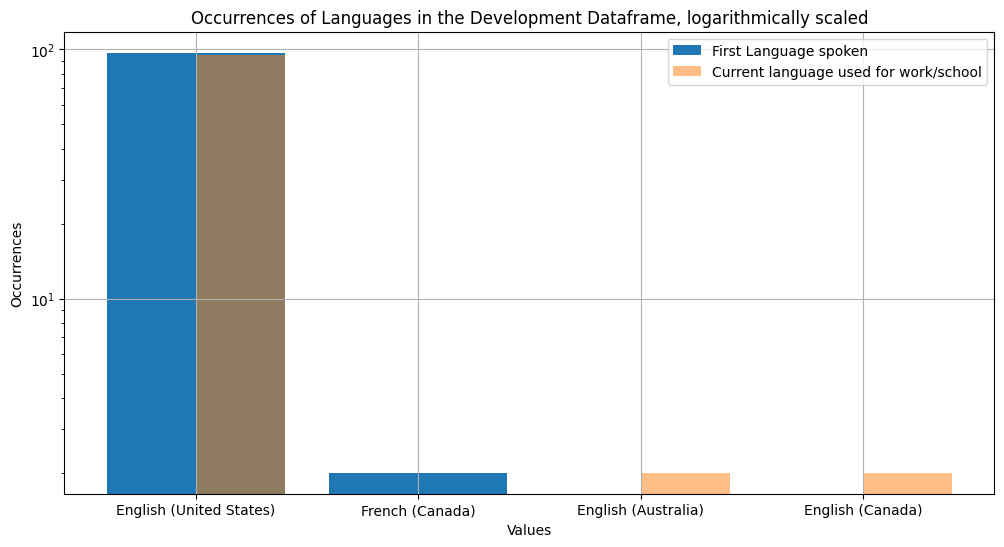

In [5]:
col1_counts = dev_df['First Language spoken'].value_counts()

# Count the occurrences of each value in the second column
col2_counts = dev_df['Current language used for work/school'].value_counts()

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(col1_counts.index, col1_counts.values, label='First Language spoken')
ax.bar(col2_counts.index, col2_counts.values, label='Current language used for work/school', width=0.4, align='edge',
       alpha=0.5)

# Add a legend and display the chart
ax.legend()
ax.set_yscale('log')  # this line add the y-axis scaling to logarithmic
plt.xlabel("Values")
plt.grid()
plt.ylabel("Occurrences")
plt.title("Occurrences of Languages in the Development Dataframe, logarithmically scaled")
plt.show()

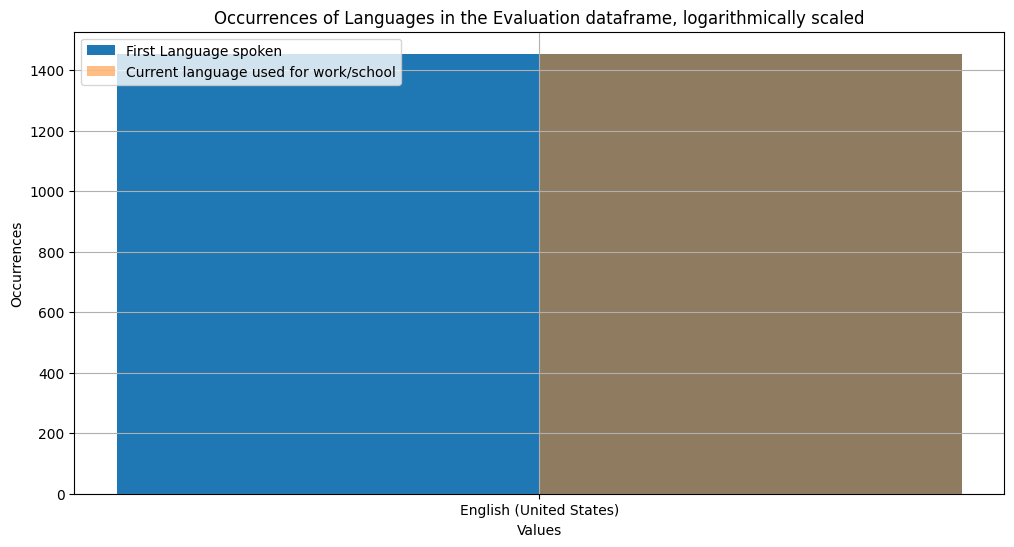

In [6]:
col1_counts = eval_df['First Language spoken'].value_counts()

# Count the occurrences of each value in the second column
col2_counts = eval_df['Current language used for work/school'].value_counts()

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(col1_counts.index, col1_counts.values, label='First Language spoken')
ax.bar(col2_counts.index, col2_counts.values, label='Current language used for work/school', width=0.4, align='edge',
       alpha=0.5)

# Add a legend and display the chart
ax.legend()
plt.xlabel("Values")
plt.grid()
plt.ylabel("Occurrences")
plt.title("Occurrences of Languages in the Evaluation dataframe, logarithmically scaled")
plt.show()

In [7]:
mapping = {dev_df.columns[4]: 'Fluency', }
dev_df = dev_df.rename(columns=mapping)
dev_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99 entries, 8353 to 8917
Data columns (total 9 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   path                                   99 non-null     object
 1   speakerId                              99 non-null     object
 2   action                                 99 non-null     object
 3   object                                 99 non-null     object
 4   Fluency                                99 non-null     object
 5   First Language spoken                  99 non-null     object
 6   Current language used for work/school  99 non-null     object
 7   gender                                 99 non-null     object
 8   ageRange                               99 non-null     object
dtypes: object(9)
memory usage: 7.7+ KB


# 2: Dataframe cleaning

In [8]:
mapping = {dev_df.columns[4]: 'Fluency',}
dev_df = dev_df.rename(columns=mapping)
dev_df.head()

,path,speakerId,action,object,Fluency,First Language spoken,Current language used for work/school,gender,ageRange
8353,dsl_data/audio/speakers/ZebMRl5Z7dhrPKRD/d4441...,ZebMRl5Z7dhrPKRD,decrease,volume,native,English (United States),English (United States),male,41-65
9843,dsl_data/audio/speakers/Pz327QrLaGuxW8Do/78636...,Pz327QrLaGuxW8Do,decrease,heat,native,English (United States),English (United States),female,22-40
1851,dsl_data/audio/speakers/BvyakyrDmQfWEABb/447cf...,BvyakyrDmQfWEABb,decrease,volume,native,English (United States),English (United States),male,22-40
7209,dsl_data/audio/speakers/xPZw23VxroC3N34k/9d35a...,xPZw23VxroC3N34k,change language,none,native,English (United States),English (United States),female,22-40
3742,dsl_data/audio/speakers/kNnmb7MdArswxLYw/42458...,kNnmb7MdArswxLYw,increase,volume,native,English (United States),English (United States),female,41-65


In [9]:
dev_df.drop(dev_df[dev_df['First Language spoken'] != 'English (United States)'].index, inplace=True)
dev_df.drop(dev_df[dev_df['Current language used for work/school'] != 'English (United States)'].index, inplace=True)
df_unique_data = get_unique_data(dev_df, 7)
df_unique_data

action                                   [decrease, change language, increase, activate...
object                                                 [volume, heat, none, music, lights]
Fluency                                                          [native, advanced, basic]
First Language spoken                                            [English (United States)]
Current language used for work/school                            [English (United States)]
gender                                                                      [male, female]
ageRange                                                               [41-65, 22-40, 65+]
dtype: object

# Extracting features

In [10]:
def create_sentence(row):
        return row["action"] + row["object"]

In [11]:
# apply the function to the dataframe
dev_df["sentence"] = dev_df.apply(create_sentence, axis=1)
dev_df.drop('action', axis=1, inplace=True)
dev_df.drop('object', axis=1, inplace=True)

In [12]:
def load_and_clean_audio(filepath):
    # Load the audio file
    y, sr = librosa.load(filepath)
    # Perform any necessary cleaning steps
    # for example removing silence at the beginning and end of the audio
    yt, _ = librosa.effects.trim(y)
    mfccs_features = librosa.feature.mfcc(y=yt, sr=sr, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

    return mfccs_scaled_features

In [13]:
# Load audio files with librosa
dev_df['normalized_mfccs'] = dev_df['path'].apply(lambda path: load_and_clean_audio(path))
dev_df.drop('path', axis=1, inplace=True)
dev_df.drop('speakerId', axis=1, inplace=True)

# Extract features
# dev_df['spectrogram'] = dev_df['audio'].apply(lambda audio: librosa.feature.melspectrogram(audio))
# print('Spect done')
# dev_df['mfcc'] = dev_df['audio'].apply(lambda audio: np.mean(librosa.feature.mfcc(audio).T,axis=0))
# print('mfcc done')
# dev_df['chroma_stft'] = dev_df['audio'].apply(
#     lambda audio: librosa.feature.chroma_stft(audio))
# print('chroma_stft done')

# dev_df.drop('audio', axis=1, inplace=True)

print(dev_df.shape)
for column in dev_df.columns:
    print(column, dev_df[column].shape)
dev_df.head()

(95, 7)
Fluency (95,)
First Language spoken (95,)
Current language used for work/school (95,)
gender (95,)
ageRange (95,)
sentence (95,)
normalized_mfccs (95,)


,Fluency,First Language spoken,Current language used for work/school,gender,ageRange,sentence,normalized_mfccs
8353,native,English (United States),English (United States),male,41-65,decreasevolume,"[-351.98438, 122.14056, -15.332986, 20.52629, ..."
9843,native,English (United States),English (United States),female,22-40,decreaseheat,"[-251.36823, 147.26747, -53.16714, 39.74105, 2..."
1851,native,English (United States),English (United States),male,22-40,decreasevolume,"[-431.15262, 63.69768, 9.783277, 31.527561, -6..."
7209,native,English (United States),English (United States),female,22-40,change languagenone,"[-277.59787, 39.165646, -43.352154, 61.132896,..."
3742,native,English (United States),English (United States),female,41-65,increasevolume,"[-290.10266, 116.57442, -47.828037, -3.450123,..."


In [14]:
# Convert categorical features to numerical values
dev_df = pd.get_dummies(dev_df, columns=['Fluency', 'First Language spoken', 'Current language used for work/school', 'gender', 'ageRange'])

for column in dev_df.columns:
    print(column, dev_df[column].shape)
dev_df.head()

sentence (95,)
normalized_mfccs (95,)
Fluency_advanced (95,)
Fluency_basic (95,)
Fluency_native (95,)
First Language spoken_English (United States) (95,)
Current language used for work/school_English (United States) (95,)
gender_female (95,)
gender_male (95,)
ageRange_22-40 (95,)
ageRange_41-65 (95,)
ageRange_65+ (95,)


,sentence,normalized_mfccs,Fluency_advanced,Fluency_basic,Fluency_native,First Language spoken_English (United States),Current language used for work/school_English (United States),gender_female,gender_male,ageRange_22-40,ageRange_41-65,ageRange_65+
8353,decreasevolume,"[-351.98438, 122.14056, -15.332986, 20.52629, ...",0,0,1,1,1,0,1,0,1,0
9843,decreaseheat,"[-251.36823, 147.26747, -53.16714, 39.74105, 2...",0,0,1,1,1,1,0,1,0,0
1851,decreasevolume,"[-431.15262, 63.69768, 9.783277, 31.527561, -6...",0,0,1,1,1,0,1,1,0,0
7209,change languagenone,"[-277.59787, 39.165646, -43.352154, 61.132896,...",0,0,1,1,1,1,0,1,0,0
3742,increasevolume,"[-290.10266, 116.57442, -47.828037, -3.450123,...",0,0,1,1,1,1,0,0,1,0


In [15]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(dev_df["normalized_mfccs"]))

TypeError: Encoders require their input to be uniformly strings or numbers. Got ['ndarray']

In [ ]:
# dev_df['mean_mfcc'] = dev_df['mfcc'].apply(lambda x: x.mean())
# dev_df['std_mfcc'] = dev_df['mfcc'].apply(lambda x: x.std())
# # dev_df['mfcc'] = dev_df['mfcc'].apply(lambda x: x.ravel())
# dev_df.drop('mfcc', axis=1, inplace=True)

In [ ]:
# dev_df['mean_chroma_stft'] = dev_df['chroma_stft'].apply(lambda x: x.mean())
# dev_df['std_chroma_stft'] = dev_df['chroma_stft'].apply(lambda x: x.std())
# # dev_df['chroma_stft'] = dev_df['chroma_stft'].apply(lambda x: x.ravel())
# dev_df.drop('chroma_stft', axis=1, inplace=True)

In [ ]:
# mfccs = librosa.feature.mfcc(y=y, sr=sr)
#
# # Extract the spectral contrast
# contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
#
# # Extract the root mean square (RMS) energy
# rms = librosa.feature.rms(y=y)

In [ ]:
for column in dev_df.columns:
    print(column, dev_df[column].shape)
dev_df.head()

In [ ]:
# dev_df = dev_df.applymap(lambda x: x[0] if isinstance(x, (list, tuple)) else x)
# dev_df.head()

In [ ]:
# Split data into training and test sets
columns_to_keep = [col for col in dev_df.columns if col != 'sentence']
dev_df["normalized_mfccs"] = dev_df["normalized_mfccs"].apply(lambda x: torch.from_numpy(x))
X = dev_df['normalized_mfccs']
y = dev_df['sentence']
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#
# # Train the model
# model = RandomForestClassifier()
#
# for column in X.columns:
#     try:
#         model.fit(X[column].values.reshape(-1,1), y)
#     except ValueError as e:
#         if 'setting an array element with a sequence' in str(e):
#             print(f'{column} is causing the error')
#
# model.fit(X_train, y_train)
#
# # Evaluate the model
# print(model.score(X_test, y_test))

In [ ]:
# from lazypredict.Supervised import LazyClassifier
# clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
# models,predictions = clf.fit(X_train, X_test, y_train, y_test)
# models

In [ ]:
import numpy as np
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
import tensorflow
import torch

# Define the model architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10)

# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
